# ArClOTs
## Welcome to the Aryl-Chloro/Tosyl (ArClOTs) Selectivity Analysis Project

## Table of Contents
* [Introduction](#Introduction)
  * [Purpose](#Purpose)
  * [Running this Code](#Running-this-Code)
  * [Documentation](#Documentation)
* [Part 1: Evaluate Feasibility of Modeling](#Part-1:-Evaluate-Feasibility-of-Modeling)
  * [Step 1: Loading Libraries](#Step-1:-Loading-Libraries)
  * [Step 2: Getting our Data out of Excel](#Step-2:-Getting-our-Data-out-of-Excel)
  * [Step 3: Change the SMILES Strings into Descriptors](#Step-3:-Change-the-SMILES-Strings-into-Descriptors)
  * [Step 4: Establishing a Baseline](#Step-4:-Establishing-a-Baseline)
  * [Step 5: Training our First Model](#Step-5:-Training-our-First-Model)
  * [Step 6: Summary and Moving Forward](#Step-6:-Summary-and-Moving-Forward)
* [Part 2: Gathering Data with High Throughput Experimentation](#Part-2:-Gathering-Data-with-High-Throughput-Experimentation)
    * [Step 1: Building on the Initial Study](#Step-1:-Building-on-the-Initial-Study)
    * [Step 2: Taking Modeling and Practical Challenges into Account](#Step-2:-Taking-Modeling-and-Practical-Challenges-into-Account)
    * [Step 3: Final Design of the HTE Plate](#Step-3:-Final-Design-of-the-HTE-Plate)
    * [Step 4: Summary and Moving Forward](#Step-4:-Summary-and-Moving-Forward)
* [Part 3: Generating Molecular Descriptors](#Part-3:-Generating-Molecular-Descriptors)
  * [Step 1: Approaching Molecular Descriptors](#Step-1:-Approaching-Molecular-Descriptors)
  * [Step 2: Choosing Molecular Descriptors](#Step-2:-Choosing-Molecular-Descriptors)
  * [Step 3: Generating Electronic Descriptors](#Step-3:-Generating-Electronic-Descriptors)
  * [Step 4: Generating Steric Descriptors](#Step-4:-Generating-Steric-Descriptors)
  * [Step 5: Summary and Moving Forward](#Step-5:-Summary-and-Moving-Forward)
* [Part 4: Modeling with HTE Data](#Part-4:-Modeling-with-HTE-Data)
  * [Step 1: Evaluating New Models](#Step-1:-Evaluating-New-Models)
  * [Step 2: Improving Models](#Step-2:-Improving-Models)
  * [Step 3: Improving our Descriptors](#Step-3:-Improving-our-Descriptors)
  * [Step 4: Summary and Moving Forward](#Step-4:-Summary-and-Moving-Forward)
* [Part 5: Evaluating Model Performance](#Part-5:-Evaluating-Model-Performance)
  * [Step 1: Validate the Trained Model](#Step-1:-Validate-the-Trained-Model)
  * [Step 2: Making Predictions with the Model](#Step-2:-Making-Predictions-with-the-Model)
  * [Step 3: Addition of Existing Phosphines](#Step-3:-Addition-of-Existing-Phosphines)
  * [Step 4: Synthesis of a New Phosphine](#Step-4:-Synthesis-of-a-New-Phosphine)
  * [Step 5: Summary and Moving Forward](#Step-5:-Summary-and-Moving-Forward)
* [Part 6: Conclusions](#Part-6:-Conclusions)

### Introduction
#### Purpose
The intent of this notebook is two-fold:
1. Investigate the reactivity of various phosphine ligands in a selected reaction to determine an ideal candidate for selective reactions.
2. Serve as an example of machine learning in small-molecule organic chemistry.

#### Running this Code
Via _Binder_ you can execute this entire script in your browser with no manual setup required, just some waiting while things are downloaded in the background. After this initial setup, you can scroll through the entire script, see how things work, and play around with different values to see how things change.

#### Documentation
There is a lot of explanation included around all of the code below to help you work through things line for line, with the idea being that you should be left with questions that you can Google and not anything more foundational.

### Part 1: Evaluate Feasibility of Modeling
Before we start running experiments and queuing up expensive simulations, we need to check if the computer can pick up on any of the data we already have. In the original publication, 12 ligands were tested to see if they preferred to insert at the chloro or the tosyl site. We can take the SMILES strings for these ligands along with the selectivity values and try training some models just to see what happens.
If we are able to see even some slight amount of predictivity, it means there is some chance that we can pick up a trend, at which point it will be worth moving forward.

##### Step 1: Loading Libraries
All machine learnings algorithms and chemistry tools that we need have (thankfully) already been written by other people, so all we need to do is install them to our notebook here and them use them freely. Here are some brief explanations of what each of these libraries is for:
 - matplotlib: makes plots
 - pandas: interfacing with excel workbooks
 - numpy: adds more datatypes to python, which need in order to store our data
 - sklearn: has all of the machine learning algorithms
 - rdkit: the infamous cheminformatics software package for loading SMILES strings into various computer-readable formats
 - openpyxl: reading from and writing to excel files
 - ccmblib: handy interface to RDKit to make fingerprint generation easier

In [37]:
%%capture
# the above line just prevents you from getting hundreds of lines of output from the downloaders
!conda install --yes -c rdkit rdkit
!pip install matplotlib pandas numpy sklearn openpyxl tabulate
!pip install git+https://github.com/vogt-m/ccbmlib
!conda install -y boost-cpp boost py-boost
!conda install -c conda-forge tpot!pip install markupsafe==2.0.1


##### Step 2: Getting our Data out of Excel
Right now, we have an excel sheet with two important columns: SMILES strings for the ligands, and the Cl:OTs selectivity. In order to get this data into Python, we use pandas like this:

In [2]:
import pandas
data = pandas.read_excel("data/original_paper_data.xlsx", engine='openpyxl')
data

,idx,ligand_name,ligand_smiles,cl_to_ots_selectivity,ln_selectivity
0,1,PPh3,P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3,99.000000,4.595120
1,2,P(p-OMePh)3,COC(C=C1)=CC=C1P(C2=CC=C(OC)C=C2)C3=CC=C(OC)C=C3,99.000000,4.595120
2,3,P(p-FPh)3,FC(C=C1)=CC=C1P(C2=CC=C(F)C=C2)C3=CC=C(F)C=C3,99.000000,4.595120
3,4,PPhMe2,CP(C)C1=CC=CC=C1,0.175439,-1.740466
4,5,PPhEt2,CCP(C1=CC=CC=C1)CC,2.200000,0.788457
5,6,PPh2Me,CCP(C1=CC=CC=C1)C2=CC=CC=C2,1.000000,0.000000
6,7,PCy3,P(C1CCCCC1)(C2CCCCC2)C3CCCCC3,1.500000,0.405465
7,8,P(n-Bu)3,CCCCP(CCCC)CCCC,1.100000,0.095310
8,9,P(i-bu)3,CC(C)CP(CC(C)C)CC(C)C,2.900000,1.064711
9,10,Bis(dicyclohexylphosphino)ferrocene,C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC=CC=C3.C1=CC=...,99.000000,4.595120


Now let's get the SMILES strings into a list, as well as the selectivity values.

In [3]:
smiles = data["ligand_smiles"].to_numpy()
smiles

array(['P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3',
       'COC(C=C1)=CC=C1P(C2=CC=C(OC)C=C2)C3=CC=C(OC)C=C3',
       'FC(C=C1)=CC=C1P(C2=CC=C(F)C=C2)C3=CC=C(F)C=C3',
       'CP(C)C1=CC=CC=C1', 'CCP(C1=CC=CC=C1)CC',
       'CCP(C1=CC=CC=C1)C2=CC=CC=C2', 'P(C1CCCCC1)(C2CCCCC2)C3CCCCC3',
       'CCCCP(CCCC)CCCC', 'CC(C)CP(CC(C)C)CC(C)C',
       'C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC=CC=C3.C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC=CC=C3.[Fe+2]',
       'CCP(CC)CC', 'CP(C)C'], dtype=object)

In [4]:
selectivity = data["ln_selectivity"].to_numpy()
selectivity

array([ 4.59511985,  4.59511985,  4.59511985, -1.74046617,  0.78845736,
        0.        ,  0.40546511,  0.09531018,  1.06471074,  4.59511985,
        0.58778666, -1.84054963])

Something to note - we are using the natural log of the selectivity value, and not the selectivity value itself. Both are included in the excel workbook, but only so that you can see the relationship between the two. We have to use the natural log of selectivity because selectivity is a ratio. Think about it like this:
 - An unremarkable ligand that did not promote selectivity at all would give a value of 1, which is fine.
 - A fantastic ligand that was highly selective for the Chloro- group would give a value of a 20 or above, which is not in and of itself a problem.
 - A fantastic ligand that was highly selective in _the other direction_ would give a value of 0.05.
 - Now, compare these two fantastic results to the unremarkable result. For the first case, the result is 19 'selectivity units' better. For the fantastic ligand in the other direction though, it is only 0.95 'selectivity units' better.
Selectivity, when presented as a ratio, is _non-linear_. So we take the natural log in order to _linearize_ it and make sure that highly performant ligands stand out in both directions of selectivity.

##### Step 3: Change the SMILES Strings into Descriptors
Your computer needs to have some representation of the molecules in order to draw conclusions about the reactivity; for this, we use RDKit. This package allows us to generate digital representations of the molecules using fingerprints. To do so, we follow this general procedure:
1. import the functions from RDKit that we need to use
2. Make two empty lists to store our molecules and fingerprints.
3. for each of the SMILES strings, generate a molecule
4. for each of the molecules, generate a molecular fingerprint

In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np

molecules = []
fingerprints = []

for smile in smiles:
    molecules.append(Chem.MolFromSmiles(smile))

for molecule in molecules:
    # start by generating the fingerprint as a bit vector, which is a list of 1's and 0's
    temp_fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, 2)
    
    # in order to use this later, we need to convert it into an array. to begin, make an empty array
    temp_array = np.array((0,), dtype=np.int8)
    
    # put the fingerprint into the array
    DataStructs.ConvertToNumpyArray(temp_fingerprint, temp_array)
    
    # save this temporary array into the fingerprint array
    fingerprints.append(temp_array)

Take a look at the cell below, which shows what the fingerprints array _actually looks like_. It is a list, and every component of the list is itself a list of 1's and 0's. Each of those sub-lists represents one of the molecules in our dataset, and the computer can interpret the 1's and 0's, as well as their relative placement to one another, as a molecule.

In [6]:
fingerprints

[array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 1, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 1, 0, 0], dtype=int8),
 array([0, 1, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8)]

##### Step 4: Establishing a Baseline
To 'train' our model, we are going to use cross-validation. First, this splits the data into a group of 75% and 25%, lets the model look at the 75% of the data, and then asks it to predict the remaining 25%. Then, it repeats this process but changes around which ligands in the 75% (training data) and which are in the 25% (testing data). This is repeated until all of the samples have been in _both_ the training data and the testing data, which gives us a much better idea of how our model is performing. Graphically, it looks like this:
<div>
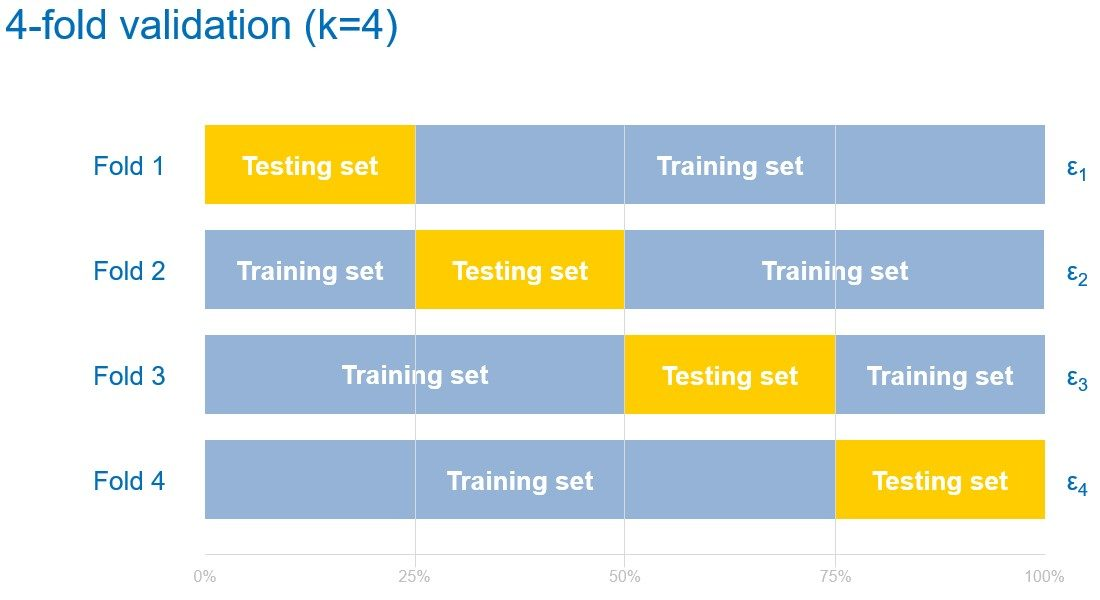
</div>

In [7]:
from sklearn.model_selection import KFold
# make our groups
groups = KFold(n_splits=6, shuffle=True, random_state=42)

In order to determine if our 'real' models are actually _learning_ anything, we need have a baseline model to which we can make comparisons. There are multiple types of baseline models, and we will explore one here: Guessing the Mean

This approach to determining the selectivity based on the ligand would be to just guess the mean selectivity from the input list every time you are a given a ligand. Sklearn (the library we use to do machine learning in Python) considers this a "dummy" model.

In [8]:
from sklearn.dummy import DummyRegressor
# setup our mean guessing model
mean_model = DummyRegressor(strategy="mean")

from sklearn.model_selection import cross_val_predict, cross_val_score
mean_score_r2 = cross_val_score(mean_model, fingerprints, selectivity, cv=groups, scoring='r2')
mean_score_MAE = cross_val_score(mean_model, fingerprints, selectivity, cv=groups, scoring='neg_mean_absolute_error')
print(f"Average R2: {mean_score_r2.mean():.2f} +/- {mean_score_r2.std():.2f}")
print(f"Average Mean Absolute Error: {-1*mean_score_MAE.mean():.2f} +/- {mean_score_MAE.std():.2f}")

Average R2: -3.35 +/- 4.70
Average Mean Absolute Error: 2.18 +/- 0.62


This is totally _dismal_ performance. The R^2 values are terrible to the point of being meaningless. The mean absolute error is actually telling us something. MAE is essentially saying "on average, how far off was each prediction?" For us, guessing the mean every time usually gave us an error of about 2.18 'ln(selectivity)'. Our dataset only included examples from -1.8 to 4.6, so this really is quite bad.

Let's plot the results and figure out why it did so poorly. The plot we are making in the code below is called a 'Prediction Error Plot'.

In [9]:
mean_predictions = cross_val_predict(mean_model, fingerprints, selectivity, cv=groups)
mean_predictions

array([1.20813631, 1.49866234, 1.31460738, 1.90761947, 1.68574261,
       1.31460738, 1.90761947, 1.68574261, 1.20813631, 1.25582871,
       1.25582871, 1.49866234])

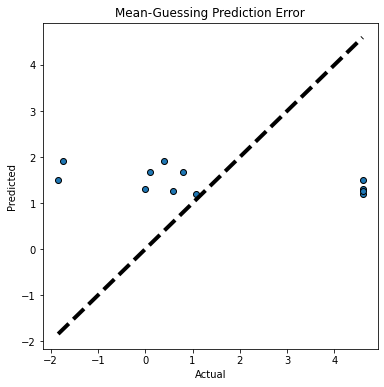

In [10]:
from helper_functions import prediction_error_plot

prediction_error_plot(selectivity, mean_predictions, title='Mean-Guessing Prediction Error')

This is clearly not learning at all, as the predictions go straight across the plot parallel to the x axis. This is the 'model' to beat.

##### Step 5: Training our First Model
Now that we have an idea of the worst case performance, let's start training some actual models to see if they can learn anything. The first one we will try will use the molecular fingerprints which we generated earlier as the input, and the type of model we train is called a Random Forest Regressor. Read about this more on [Wikipedia](https://en.wikipedia.org/wiki/Random_forest).
This code is copy-pasted from above, with just some minor changes to which model it uses. If we wanted to, we could put all of this into it's own separate function, but that would get really confusing really fast, so we will stick with this.

In [11]:
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor(criterion="absolute_error")

random_forest_score_r2 = cross_val_score(
    random_forest_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='r2',
)
random_forest_score_MAE = cross_val_score(
    random_forest_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='neg_mean_absolute_error',
)
print(f"Average R2: {random_forest_score_r2.mean():.2f} +/- {random_forest_score_r2.std():.2f}")
print(f"Average Mean Absolute Error: {-1*random_forest_score_MAE.mean():.2f} +/- {random_forest_score_MAE.std():.2f}")

Average R2: -0.66 +/- 1.21
Average Mean Absolute Error: 1.73 +/- 0.83


An improvement but still not great. Let's look at the plot.

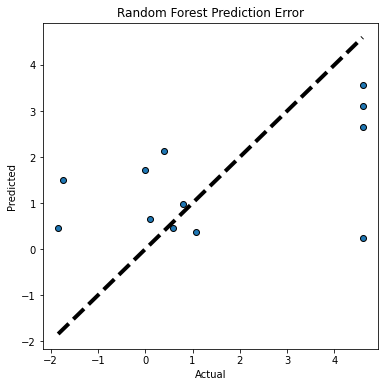

In [12]:
random_forest_predictions = cross_val_predict(random_forest_model, fingerprints, selectivity, cv=groups)
prediction_error_plot(selectivity, random_forest_predictions, title='Random Forest Prediction Error')

While the error metrics don't look great on this model, the plot tells a slightly different story. The random forest model is learning _something_ because there is some slight curvature to the plot, in addition to the increased accuracy. Let's try another model, this time the Nearest-Neighbors ([Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)), to see if it makes a difference.

Average R2: -1.14 +/- 1.38
Average Mean Absolute Error: 1.98 +/- 0.74


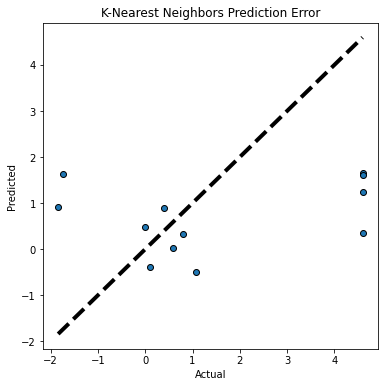

In [13]:
from sklearn.neighbors import KNeighborsRegressor
neighbors_model = KNeighborsRegressor()

neighbors_score_r2 = cross_val_score(
    neighbors_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='r2',
)
neighbors_score_MAE = cross_val_score(
    neighbors_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='neg_mean_absolute_error',
)
print(f"Average R2: {neighbors_score_r2.mean():.2f} +/- {neighbors_score_r2.std():.2f}")
print(f"Average Mean Absolute Error: {-1*neighbors_score_MAE.mean():.2f} +/- {neighbors_score_MAE.std():.2f}")

random_forest_predictions = cross_val_predict(neighbors_model, fingerprints, selectivity, cv=groups)
prediction_error_plot(selectivity, random_forest_predictions, title='K-Nearest Neighbors Prediction Error')

K-Nearest Neighbors is not particularly outstanding here. The R^2 value is a bit better than the baseline model, but not as good as the random forest, and the error is pretty much equal to the baseline.

Just for completeness sake, let's train a Linear Regression and see how it does.

Average R2: -0.11 +/- 1.01
Average Mean Absolute Error: 1.31 +/- 0.62


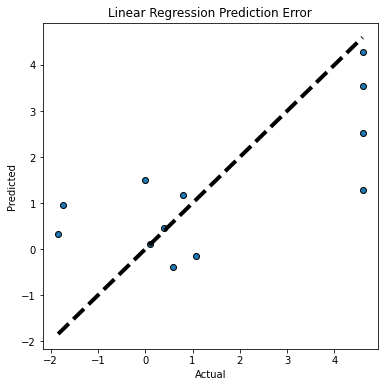

In [14]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()

linear_score_r2 = cross_val_score(
    linear_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='r2',
)
linear_score_MAE = cross_val_score(
    linear_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='neg_mean_absolute_error',
)
print(f"Average R2: {linear_score_r2.mean():.2f} +/- {linear_score_r2.std():.2f}")
print(f"Average Mean Absolute Error: {-1*linear_score_MAE.mean():.2f} +/- {linear_score_MAE.std():.2f}")

linear_predictions = cross_val_predict(linear_model, fingerprints, selectivity, cv=groups)
prediction_error_plot(selectivity, linear_predictions, title='Linear Regression Prediction Error')

Surprise, surprise! Simple linear regression is actually able to decrease the overall error, increase the R^2, _and_ get some of the ligands correct. Linear regression is actually a reasonable approach to take here, given how few data points we have. 

##### Step 6: Summary and Moving Forward
Now that we have some models and results in hand, let's throw them into a nice table and see how we are doing.

In [27]:
from tabulate import tabulate
table = tabulate(
    [["Mean Baseline",mean_score_r2.mean(),-1*mean_score_MAE.mean()],
     ["Random Forest",random_forest_score_r2.mean(),-1*random_forest_score_MAE.mean()],
     ["K-Nearest",neighbors_score_r2.mean(),-1*neighbors_score_MAE.mean()],
     ["Linear",linear_score_r2.mean(),-1*linear_score_MAE.mean()]],
    headers=["Model","R2","MAE"],
    floatfmt=".2f",
    tablefmt='grid',
)
print(table)

+---------------+-------+-------+
| Model         |    R2 |   MAE |
+===============+=======+=======+
| Mean Baseline | -3.35 |  2.18 |
+---------------+-------+-------+
| Random Forest | -0.79 |  1.67 |
+---------------+-------+-------+
| K-Nearest     | -1.14 |  1.98 |
+---------------+-------+-------+
| Linear        | -0.11 |  1.31 |
+---------------+-------+-------+


Using an online comparison of means calculator (you could do this in Python, but... why?) we can determine that the Linear Regression model is statistically different from the Baseline based on the MAE, which is a good sign. Without the incorporation of any specific descriptors or any tuning of the models, we have been able to beat the baseline.

Armed with this, we can move forward to the next step of the investigation.

### Part 2: Gathering Data with High Throughput Experimentation
Now that we know a model could _theoretically_ learn and predict from data about this problem, we need to generate some additional data. Any model that we train is going to need to have enough results to look at and draw conclusions -- by increasing the amount of data, we can drown out experimental and random error, increase the total range of selectivity represented in the data, and give the model enough evidence from which to draw conclusions. 

We are going to do this by High Throughput Experimentation, screening a set of phosphine ligands. Our choice of ligands is going to be guided by the idea of exploring more "chemical space". This means we want to add some phosphines that the data does not include right now, but also try phosphines which are combinations of existing ligands already in the data (and would therefore 'fill in the gap' between existing data points.

##### Step 1: Building on the Initial Study
The initial study included the 12 phoshpine ligands listed below:

|Number|Ligand|
|---|---|
|1| triphenylphosphine|
|2| tri(4-methoxyphenyl)phosphine|
|3| tri(4-fluorophenyl)phosphine|
|4|dimethylphenylphosphine|
|5|diethylphenylphosphine|
|6|diphenylmethylphosphine|
|7|tricyclohexylphosphine|
|8|tributylphosphine|
|9|tri(iso-butyl)phosphine|
|10|bis(diclyclohexylphosphino)ferrocene|
|11|triethylphosphine|
|12|trimethylphosphine|

First, let's think about things we need to add. Experience tells us that this table is missing a few notable functional groups, substitution patterns, and ligand archetypes. In our HTE experiment, we need to add the tert-butyl, adamantyl, amine, and benzyl groups. We will also add some alkyl-substituted aryl groups. Finally, we will add a ligand from the Buchwald class, conspicuously absent from this initial study.

Second, let's think about what combinations of existing pieces we want to explore. Thankfully, phosphine chemistry is pretty well established and we can more or less mix-and-match alkyl and aryl groups to our heart's desire. We will try ethyldiphenylphosphine, which is a combination of methyldiphenylphosphine and diethylphenylphosphine, in order to explore the chemical space between our existing examples.

##### Step 2: Taking Modeling and Practical Challenges into Account
As part of our HTE screen, we definitely want to include the ligands from the original study in order to ensure reproducibility. However, there are some out of this set of 12 which we cannot readily include.

First, the trimethylphosphine would be quite difficult to run in our HTE format. Because the boiling point is around 36 degrees Celsius, we cannot readily 'plate' the ligand (deposit the solid in an HTE vial). While we _could_ run a separate reaction on the bench using trimethylphosphine, this would introduce new question of systematic error which we could not address. For this reason, we will leave trimethylphosphine out.

Second is the bidentate ferrocene ligand. There are two challenges with this species which we are not yet equipped to deal with, and they both occur on the modeling side:
 1. Our simulations used for calculating descriptors do not take into account the number of ligands coordinated to the transition metal center.

This an issue because of systematic error. In our treatment of the system, we ignore the ligation state of the nickel and generate our molecular descriptors based on _only_ a single phosphine. This is 'wrong' (since the complex likely has at least 2 ligands) but because we treat every ligand the same way, our results will not be affected. In the case of bidentate ligands, we cannot make this same underlying assumption, as the bidentate may be the only ligand in the complex and therefore any descriptors generated would actually be giving a complete picture.
Think of it this way: we have a balance which we _know_ is consistently off by a given amount. If we measure all of our chemicals without calibrating it, the values might not be representative of the _actual_ value, but they will all be wrong by the _same amount_. If we were to calculate molecular descriptors for the bidentate phosphine, this would be like calibrating the balance correctly for only _one_ of the compounds we measure.

 2. Ferrocene does not readily converge in computational chemistry simulations when simulated on its own.

As we will discuss in greater detail below, we are going to calculate molecular descriptors for these phosphines by treating them as three separate fragments -- each of the three substituents on the central phosphorus is one fragment. The challenge with this approach is that ferrocene will often not work in simulations unless it is part of the entire molecule. For this reason, we will leave it out of the dataset.

##### Step 3: Final Design of the HTE Plate
With all of the above considerations in mind, here is the layout of the final 96-well HTE plate proposed for initial investigation:

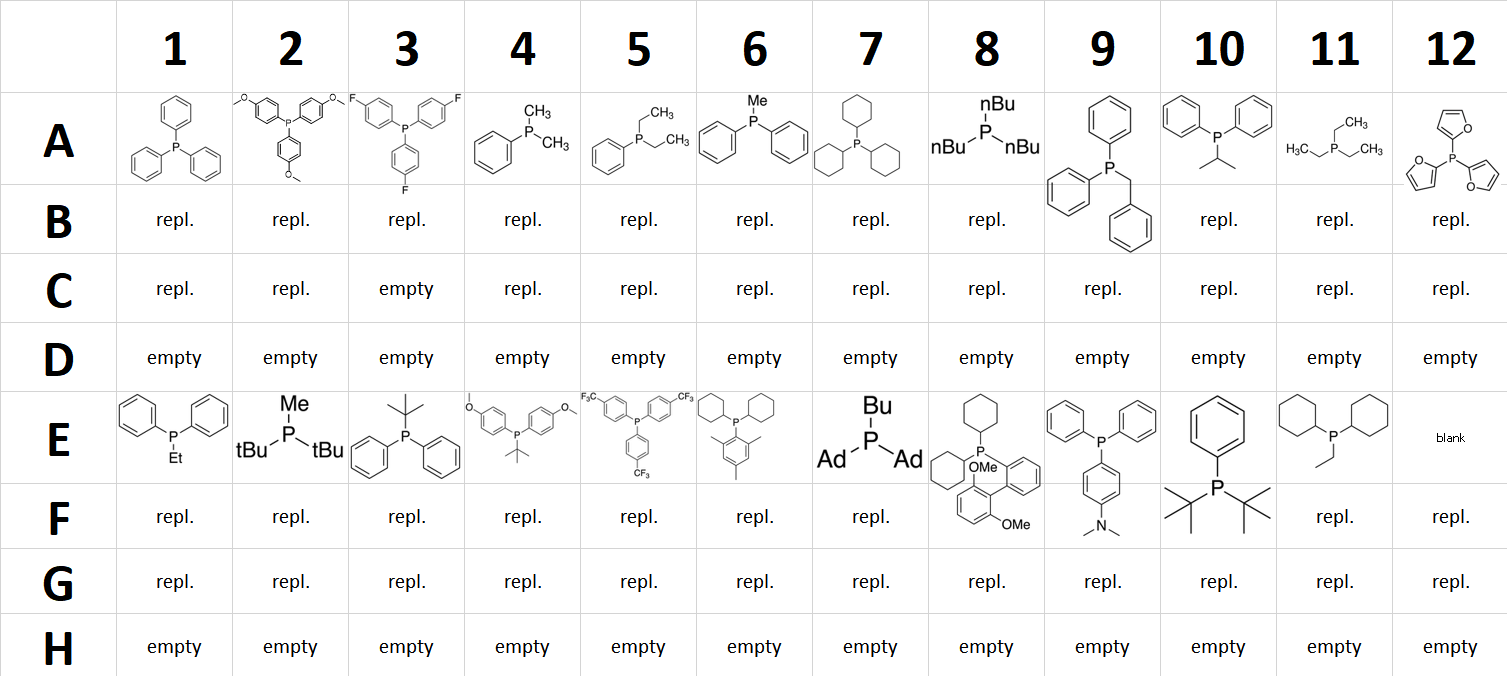

First and foremost -- for each of the ligands on the plate, we will run 4 replicates. This gives us enough data to throw out failed reactions (from bad plating, solvent evaporation, failed injections, etc.) and to do some error analysis, if required.
Now, let's look at the ligands themselves. The top row of 12 is the same as the original study, except those few from the original dataset which we mentioned would be impractical to implement have been replaced by other phosphines. In the second row we have entirely new phosphines selected from our ligand library. Among all of the new phosphines, we have added Buchwald-types ligands, heterocycles, and a number of functional groups which were not present before. Many of the new additions are also combinations of ligands which were already present, such as the aforementioned ethyldiphenylphosphine. We only have 24 ligands total, but we are going to be able to run this all at once and analyze it automatically overnight -- the _rate_ at which we are generating data is enormous.

##### Step 4: Summary and Moving Forward
With this plate design in hand, we need to actually do some legwork and generate the data. This involves designing the experiment to involve as few additions as possible, picking out vials of ligand to put into the plate, spinning it under vacuum, letting the LC/MS sample each well, and retrieving the data off the computer. We also need a calibration curve to correlate this back into yields afterward, from which we can calculate selectivity values like we have above.

These steps will not be covered in the tutorial, so moving forward we are going to assume you have done all the analysis and now have access to a table of data that looks something like this:

|Ligand|ln(Selectivity)|
|---|---|
|triethylphoshine|1.2|
|diphenylbenzylphosphine|0.5|

...and so on.

In [18]:
new_data = pandas.read_excel("data/new_data.xlsx", engine='openpyxl')
new_data

,number,Ligand,Name,SMILES,starting_material,Ots_product,Cl_product,Selectivity,ln(Selectivity)
0,1,17,Triphenylphosphine,c3c(P(c1ccccc1)c2ccccc2)cccc3,65.832684,3.117063,2.299811,1.355356,0.304064
1,2,11,Tris(4-methoxyphenyl)phosphine,O(c3ccc(P(c1ccc(OC)cc1)c2ccc(OC)cc2)cc3)C,72.005271,4.883085,2.562095,1.905896,0.644952
2,3,227,Tris(4-fluorophenyl)phosphine,FC1=CC=C(C=C1)P(C2=CC=C(F)C=C2)C3=CC=C(F)C=C3,66.396229,2.957885,2.272104,1.301826,0.263768
3,4,0,dimethylphenylphosphine,CP(C)C1=CC=CC=C1,42.534122,3.582276,9.225814,0.388288,-0.946007
4,5,0,diethylphenylphosphine,CCP(CC)c1ccccc1,55.664500,3.747146,3.592148,1.043149,0.042244
5,6,8,Methyldiphenylphosphine,CP(C1=CC=CC=C1)C2=CC=CC=C2,61.468108,2.671625,2.233635,1.196089,0.179057
6,7,4,Tricyclohexylphosphine,C1(CCCCC1)P(C2CCCCC2)C3CCCCC3,58.623200,3.306733,2.849185,1.160589,0.148927
7,8,2,tri-n-butylphosphine,CCCCP(CCCC)CCCC,64.839543,2.670439,2.235873,1.194361,0.177611
8,9,63,Benzyldiphenylphosphine,c3ccc(CP(c1ccccc1)c2ccccc2)cc3,56.907488,10.747915,2.657613,4.044199,1.397283
9,10,353,Isopropyldiphenylphosphine,CC(C)P(C1=CC=CC=C1)C2=CC=CC=C2,66.744513,2.671185,2.236743,1.194230,0.177501


### Part 3: Generating Molecular Descriptors

##### Step 1: Approaching Molecular Descriptors
As we have discussed above, the computer can't just take this data and turn it into some sort of perfectly-predictive program. We need to describe the results to the computer in a way that it can understand such that it can start to learn what causes the various trends in the data. We do this with __descriptors__.

Above, we used a very simple descriptor: the molecular fingerprint. This was a list of ones and zeros generated by an algorithm to represent the various substructures in the molecule. But molecular descriptors can be almost _anything_ that a computer can understand -- functions, lists, scalar values, etc.

For years chemists have developed _tons_ of descriptors for their Quantitative Structure-Activity Relationship (QSAR) Studies or as tools to help them understand reactions. Relative Gibbs free energies, buried volume, mulliken charges, HOMO-LUMO gaps, A-values, molecular graphs, even the molecular weight can all be used as molecular descriptors.

Now, how do we choose which of these to use?
 - In some cases, the decision is made for us by how the descriptor is defined. 
For this case study, phosphines have a descriptor called the Percent Buried Volume (%BV), which is a measurement of how much space around the central metal atom in a transition metal-ligand complex is occupied by the ligand. While this would be massively helpful for determining the ease with which one could form an oxidative addition complex, in different reactions this would be useless.
 - In most cases, we prefer to 'throw descriptors at the wall and see what sticks'
We humans would be unable to make sense of one thousand different descriptors for a reaction, but for a machine that's the perfect situation. The computer can make sense of trends in descriptors which we would never notice, and with clever coding we can eliminate descriptors which are actually useless.

Now, we know what descriptors are and why they are useful, but how do we actually get them? The typical literature approach is to run a DFT simulation for every ligand in the dataset. Using the converged structure, we can calculate all the necessary parameters with Gaussian or small python scripts. Other groups have already taken care of this and graciously published their results online. Check out the [kraken](https://kraken.cs.toronto.edu/) database, which contains tons of descriptors for almost any phosphine that you can draw.

Our unique approach, and the one we will cover in this case study, is more of a hybrid. Full DFT analysis for every single ligand in a large dataset can take months, burning up hundreds of thousands of hours of computational time. This is primarily due to the fact that DFT simulations scale at a rate of n^3 where n in the number of electrons in the system. Our alternative approach is to break each phosphine into pieces, simulate small fragments with DFT, and then run the entire molecule with simple Monte-Carlo simulations. 

Take dimethylphenylphosphine, for example. First, we break the species up into three fragments -- the two methyl groups, and the phenyl group. We simulate a dihydromethyl and dihydrophenylphosphine using DFT (a lighting-fast simulation because of the small size) in order to retrieve electronic parameters such as the HOMO-LUMO gap or partial charges. For the entire species, we run a simple molecular dynamics simulation. This can be used to describe steric descriptors, such as bond angles and buried volume, which are mostly controlled by the physical space constraints of the atoms and not the electronic interactions of the fragments (at least, that's the hypothesis).

An additional strength of this approach is that once we have all of the electronic descriptors in hand, we can recombine that at will to design new 'virtual' phosphines. Then, with a simple molecular dynamics simulation, we can get all of the descriptors we need to find out how it does. More on this later.

##### Step 2: Choosing Molecular Descriptors
As mentioned above, we generally try to just throw every descriptor we can into the computer and see if we can get something meaningful out of the other end. Because we are studying a reaction with phosphine complexes, we can add specially-designed descriptors like the buried volume and sterimol parameters as well.
 
##### Step 3: Generating Electronic Descriptors
Electronic descriptors are generated using Gaussian, and that's about as much as I know. As far as what basis set to use, how to actually set up simulations, and how to read through the 20,000 line long Gaussian output files, you will need to talk to a computational chemist. For now, let's just assume that for every fragment we need, we have the various electronic descriptors in an excel file.

##### Step 4: Generating Steric Descriptors
Molecular Dynamics can be done in a ton of different places, but our weapon of choice is MacroModel. It can be easily run on a remote machine, has a handy user interface, and has Monte Carlo Multiple Minimum (MCMM) built in. We will take every complete phosphine, run it through a MCMM simulation and get back an ensemble of possible conformers for the molecule, each with a relative energy to the others. From each of these conformers (which MacroModel gives us as an xyz file of coordinates), we can calculate the buried volume and sterimol parameters.

~~All said and done, we should end up with an excel sheet that looks something like this:~~
For the time being, we are going to just generate some more descriptors in the same way as above as a proof of concept.

In [25]:
new_molecules = []
new_fingerprints = []

new_smiles = new_data["SMILES"].to_numpy()[:-1]

for smile in new_smiles:
    new_molecules.append(Chem.MolFromSmiles(smile))

for molecule in new_molecules:
    # start by generating the fingerprint as a bit vector, which is a list of 1's and 0's
    temp_fingerprint = AllChem.GetMorganFingerprintAsBitVect(
        molecule,
        2,
        nBits=2048*4,  # make the fingerprint longer
    )
    
    # in order to use this later, we need to convert it into an array. to begin, make an empty array
    temp_array = np.array((0,), dtype=np.int8)
    
    # put the fingerprint into the array
    DataStructs.ConvertToNumpyArray(temp_fingerprint, temp_array)
    
    # save this temporary array into the fingerprint array
    new_fingerprints.append(temp_array)
    
new_fingerprints

[array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 1, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 array([0,

##### Step 5: Summary and Moving Forward
Now that we have descriptors in hand, we can start some more modeling. Let's see what happens!

### Part 4: Modeling with HTE Data

##### Step 1: Evaluating New Models
Let's revisit our previous models with new data and see how they turn out.

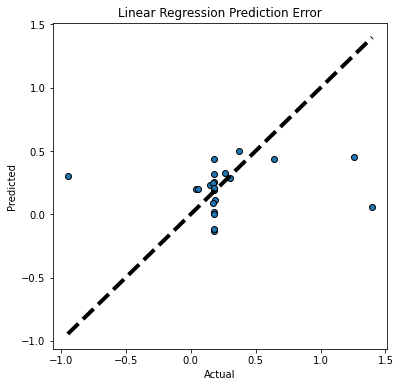

+---------------+--------+-------+
| Model         |     R2 |   MAE |
+===============+========+=======+
| Mean Baseline |  -3.35 |  2.18 |
+---------------+--------+-------+
| Random Forest |  -5.04 |  0.21 |
+---------------+--------+-------+
| K-Nearest     | -21.99 |  0.28 |
+---------------+--------+-------+
| Linear        | -14.89 |  0.25 |
+---------------+--------+-------+


In [36]:
new_selectivity = new_data["ln(Selectivity)"].to_numpy()[:-1]

# make our groups
groups = KFold(n_splits=6, shuffle=True, random_state=42)

new_mean_model = DummyRegressor(strategy="mean")

new_mean_score_r2 = cross_val_score(mean_model, fingerprints, selectivity, cv=groups, scoring='r2')
new_mean_score_MAE = cross_val_score(mean_model, fingerprints, selectivity, cv=groups, scoring='neg_mean_absolute_error')

new_random_forest_model = RandomForestRegressor(criterion="absolute_error")

new_random_forest_score_r2 = cross_val_score(
    new_random_forest_model,
    new_fingerprints,
    new_selectivity,
    cv=groups,
    scoring='r2',
)
new_random_forest_score_MAE = cross_val_score(
    new_random_forest_model,
    new_fingerprints,
    new_selectivity,
    cv=groups,
    scoring='neg_mean_absolute_error',
)

new_neighbors_model = KNeighborsRegressor()

new_neighbors_score_r2 = cross_val_score(
    new_neighbors_model,
    new_fingerprints,
    new_selectivity,
    cv=groups,
    scoring='r2',
)
new_neighbors_score_MAE = cross_val_score(
    new_neighbors_model,
    new_fingerprints,
    new_selectivity,
    cv=groups,
    scoring='neg_mean_absolute_error',
)

new_linear_model = LinearRegression()

new_linear_score_r2 = cross_val_score(
    new_linear_model,
    new_fingerprints,
    new_selectivity,
    cv=groups,
    scoring='r2',
)
new_linear_score_MAE = cross_val_score(
    new_linear_model,
    new_fingerprints,
    new_selectivity,
    cv=groups,
    scoring='neg_mean_absolute_error',
)

new_table = tabulate(
    [["Mean Baseline",new_mean_score_r2.mean(),-1*new_mean_score_MAE.mean()],
     ["Random Forest",new_random_forest_score_r2.mean(),-1*new_random_forest_score_MAE.mean()],
     ["K-Nearest",new_neighbors_score_r2.mean(),-1*new_neighbors_score_MAE.mean()],
     ["Linear",new_linear_score_r2.mean(),-1*new_linear_score_MAE.mean()]],
    headers=["Model","R2","MAE"],
    floatfmt=".2f",
    tablefmt='grid',
)


linear_predictions = cross_val_predict(new_linear_model, new_fingerprints, new_selectivity, cv=groups)
prediction_error_plot(new_selectivity, linear_predictions, title='Linear Regression Prediction Error')
print(new_table)

##### Step 2: Improving Models
Let's compare the above result to the previous table:

In [32]:
print(table)

+---------------+-------+-------+
| Model         |    R2 |   MAE |
+===============+=======+=======+
| Mean Baseline | -3.35 |  2.18 |
+---------------+-------+-------+
| Random Forest | -0.79 |  1.67 |
+---------------+-------+-------+
| K-Nearest     | -1.14 |  1.98 |
+---------------+-------+-------+
| Linear        | -0.11 |  1.31 |
+---------------+-------+-------+


Our R^2 values are much better, but mainly because this new set of data is very tightly distributed around the center of the range (unremarkable selectivity). Typically at this point we would return to experimentation and try to cover more of the range more evenly by generating more data, but for this example let's move forward and try and improve the models we have on hand.

##### Step 3: Improving our Descriptors
There are a handful of options for making these models better (Google these if you are a masochist): descriptor augmentation, combining descriptors, feature selection (descriptor ablation). Thankfully, there are other people who have already figured this out, and they were kind enough to write a program that automatically tries improving models for us. There is a lot of complicated machine learning and computer science going on in this next section of code, but taken at face value this is an algorithm that automatically makes better ML models for us.

In [53]:
from tpot import TPOTRegressor

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    new_fingerprints,
    new_selectivity,
    train_size=0.75,
    test_size=0.25,
    random_state=42,
)

tpot = TPOTRegressor(
    generations=3,
    population_size=5,
    verbosity=2,
    random_state=42,
    scoring='neg_mean_absolute_error',
)
tpot.fit(np.array(X_train), np.array(y_train))
print("Best MAE:", -1*tpot.score(np.array(X_test), np.array(y_test)))
tpot.export('tpot_result.py')

                                                                                                                       
Generation 1 - Current best internal CV score: -0.16422779952302569
                                                                                                                       
Generation 2 - Current best internal CV score: -0.16422779952302569
                                                                                                                       
Generation 3 - Current best internal CV score: -0.1566420432903398
                                                                                                                       
Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=0.001, loss=exponential, n_estimators=100)
Best MAE: 0.2710735518716491


##### Step 4: Summary and Moving Forward
We now have a model that is pretty accurate! What can we do with it? Let's explore.

### Part 5: Evaluating Model Performance

##### Step 1: Validate the Trained Model
Holdout sets, straw models with random descriptors.

##### Step 2: Making Predictions with the Model
Use combinatorially generated ligands and ask the model how they will perform. When we have one that the model likes, synthesize it and see if the prediction holds true.

##### Step 3: Addition of Existing Phosphines
Experimental evaluation is absolutely key to verifying model performance.

##### Step 4: Synthesis of a New Phosphine


##### Step 5: Summary and Moving Forward


### Part 6: Conclusions